# 1. Abstract

We use the TS(Time Series) data of circulation pump offered by Skolkovo Institute of Science and Technology. These data are 8-dimensional TS data obtained from sensors. 

First of all, we visualize the data by TS plotting  and calculating the correlation coefficient. 
Next, we implement data splitting, smoothing and standardization.

When we make the anomaly detecting model using LightGBM, we start by data processing which is appropriate for LightGBM.

After this, we train the model using the training data and search the hyper parameter like learning_rate, max_depth randomly using the validation data.
Finally, we assess the generalization performance using the test data.

# 2. About dataset

We use the TS data of circulation pump offered by Skolkovo Institute of Science and Technology. These data are 8-dimensional TS data obtained from sensors.
So, we have 8 dimensional characteristics.

【Characteristics】

①Accelerometer1RMS  

②Accelerometer2RMS

③Current            

④Pressure

⑤Temperature        

⑥Thermocouple

⑦Voltage            

⑧Volume Flow RateRMS

We explain each characteristics using below figure. At first, the dynamics of water circulation is as follows: water in a tank is circulating by a water pump.

Accelerometer1RMS and Accelerometer2RMS are the data obtained from vibration sensor.

Current and Voltage are motor's value.

Pressure,Thermocouple,Volume Flow RateRMS are the data related to circulated water.

Temperature is the engine body's value.

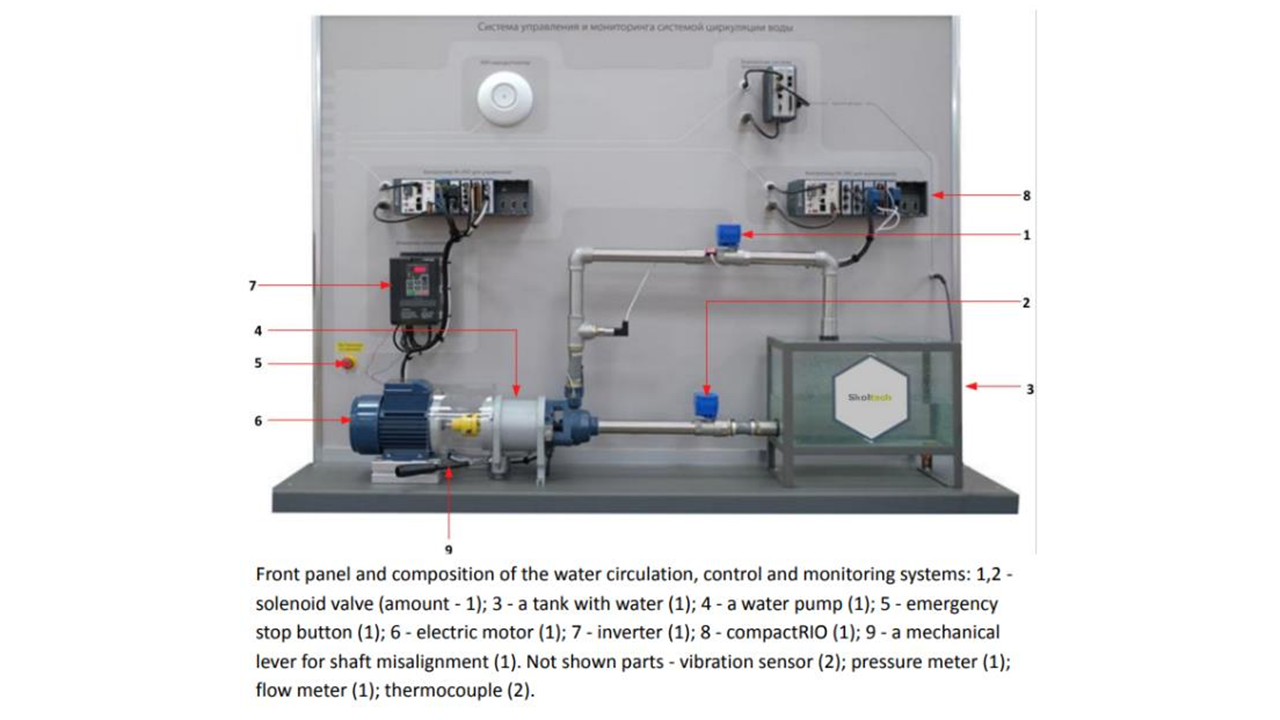

In this TS data, we are given the supervised data(normal:0 anomaly:1) for each time point and we use the valve1_data. The valve_1 data includes the anomaly waveform occurring when valve is closed. 

The purpose of this data analysis is that we let the model understand the relation between the TS waveform and the anomaly as the supervised learning.
Finally, we want the model to predict the anomaly for unknown data.

As the supervised learning method, we introduce the window which is parameterized by "look_back" and calculate the stat. like mean, min and max within the window area. 
We adopt them the explanatory variable. 

Also, we set the anomaly label at the right end of window as the objective variable and construct the predict model by LightGBM.

For the furthermore detail information, you can check below URL:
https://www.kaggle.com/datasets/yuriykatser/skoltech-anomaly-benchmark-skab

# 3. Visualize the data

**loading of valve1_data**

Valve1_data consists of the number of data : 18162 , normal class number of data : 11853 and anomaly class number of data : 6309.

In [1]:
import os
import numpy as np 
import pandas as pd 
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
path_to_data = './data/'
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))
all_files.sort()


In [3]:
valve1_dat={file.split('/')[-1]:pd.read_csv(file,sep=';',index_col='datetime',parse_dates=True)
              for file in all_files if 'valve1' in file}

#concatenate data(order in time series by sort_index)
valve1_data=pd.concat(list(valve1_dat.values()),axis=0).sort_index()
display(valve1_data)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0000,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0000,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0000,0.0,0.0
2020-03-09 10:14:36,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0000,0.0,0.0
2020-03-09 10:14:37,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 15:34:37,0.027605,0.039760,0.622996,0.382638,68.4247,24.4370,230.358,32.9673,0.0,0.0
2020-03-09 15:34:38,0.027286,0.039613,0.600692,0.054711,68.0598,24.4356,231.373,32.0000,0.0,0.0
2020-03-09 15:34:39,0.027203,0.041440,0.450323,0.054711,68.1836,24.4379,210.605,32.0337,0.0,0.0


Changepoint is not necessary because we consider the outlier detection problem.

**TS plotting**

We plot TS data(valve1_data) for each characteristics.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


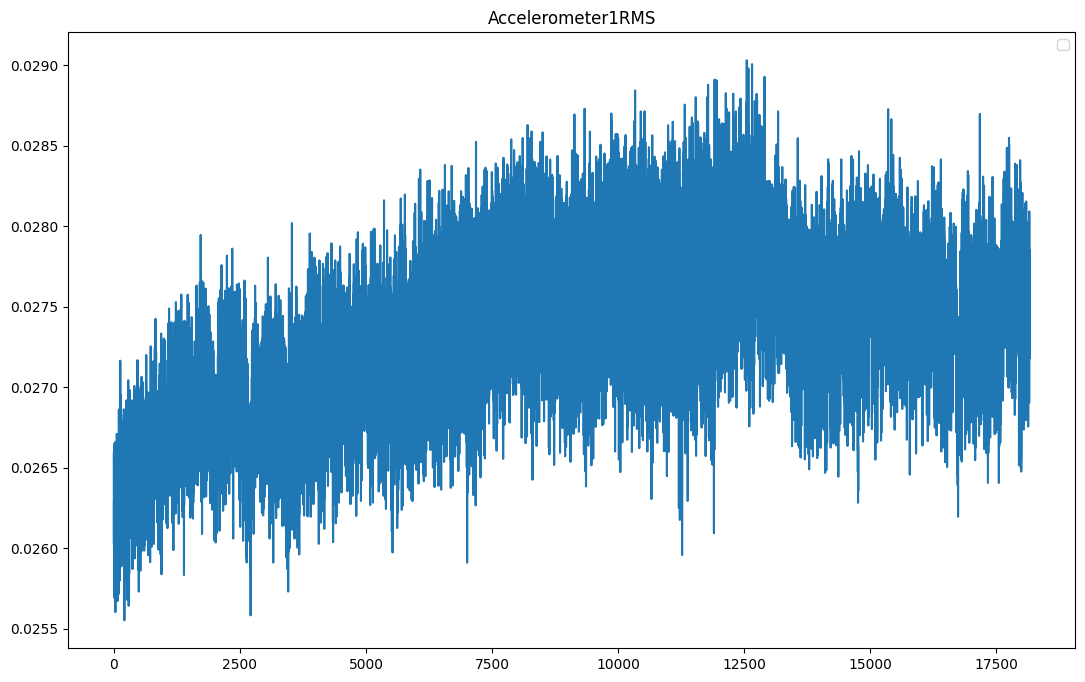

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


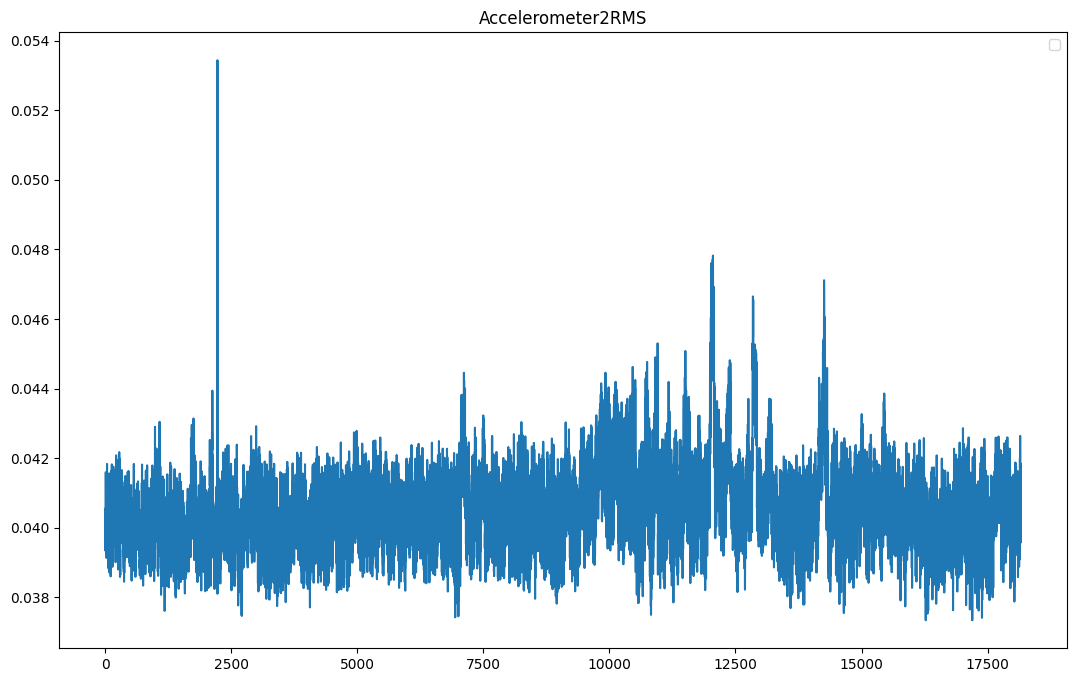

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


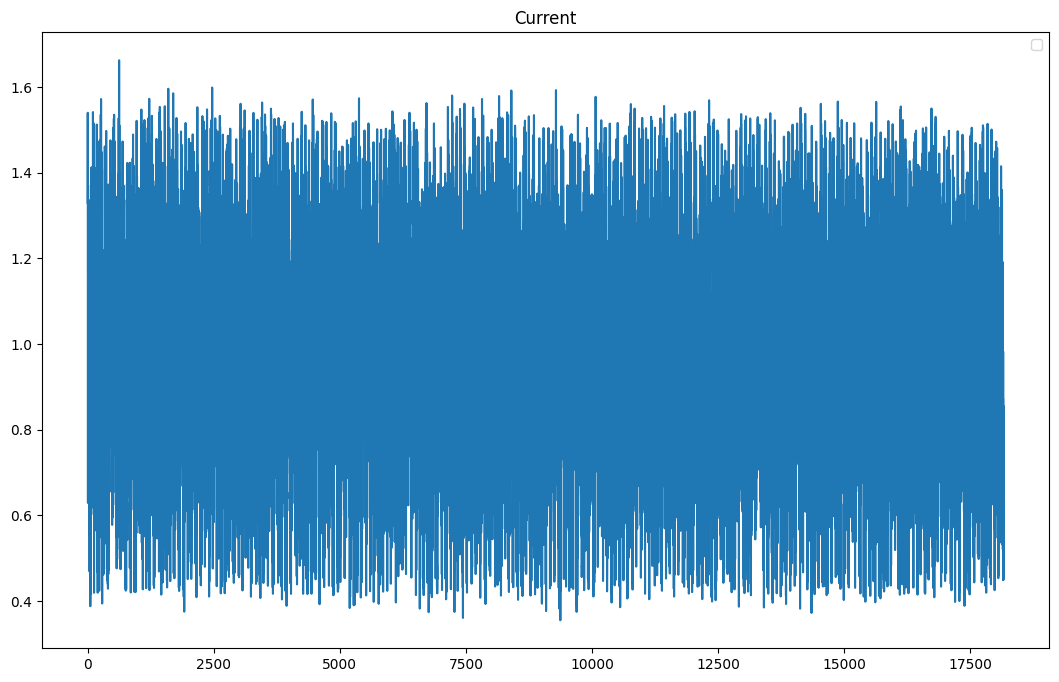

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


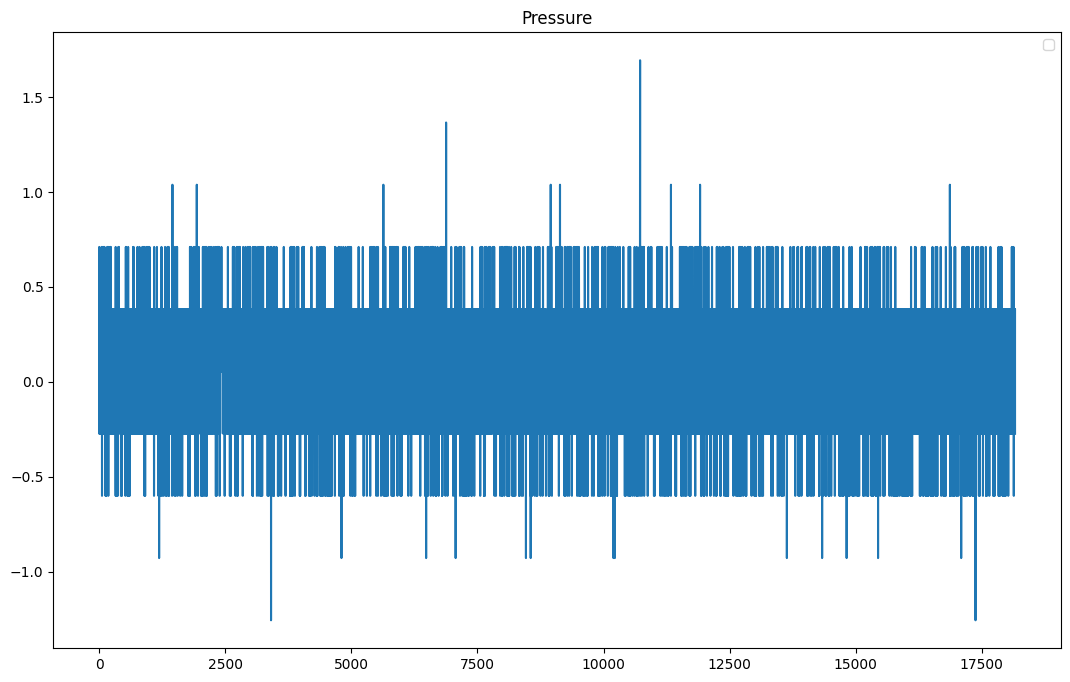

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


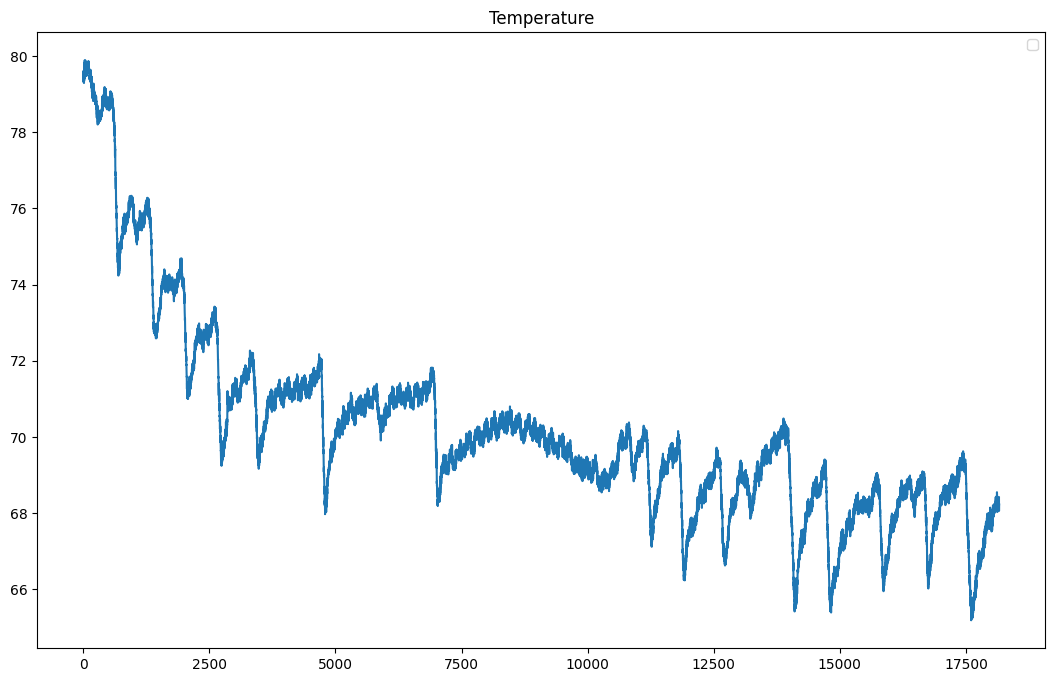

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


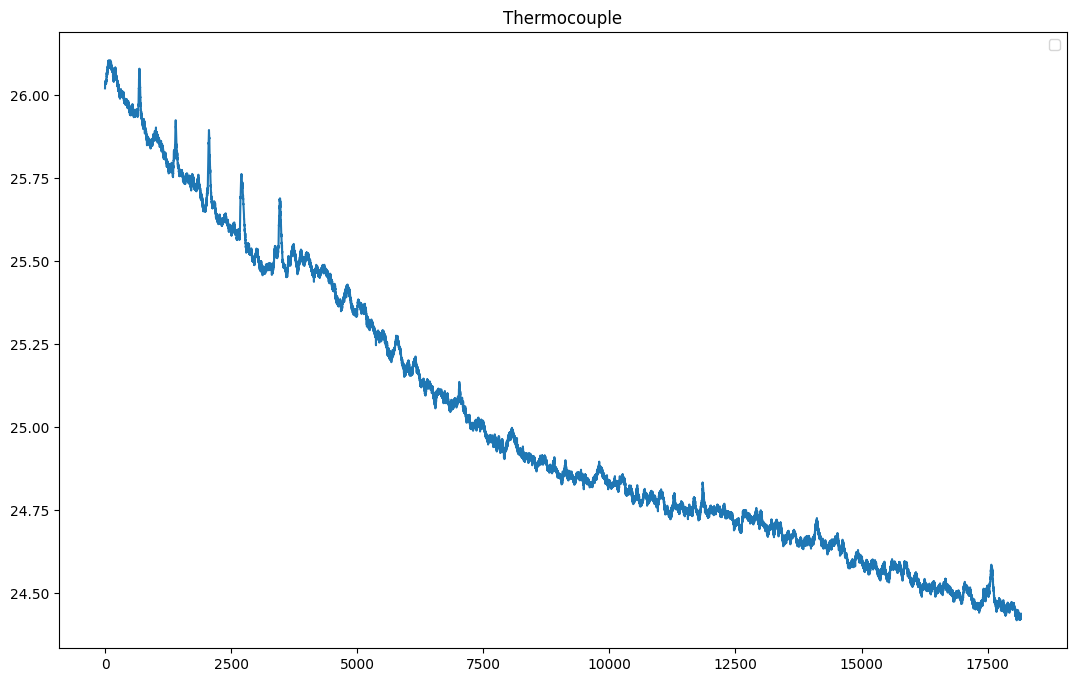

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


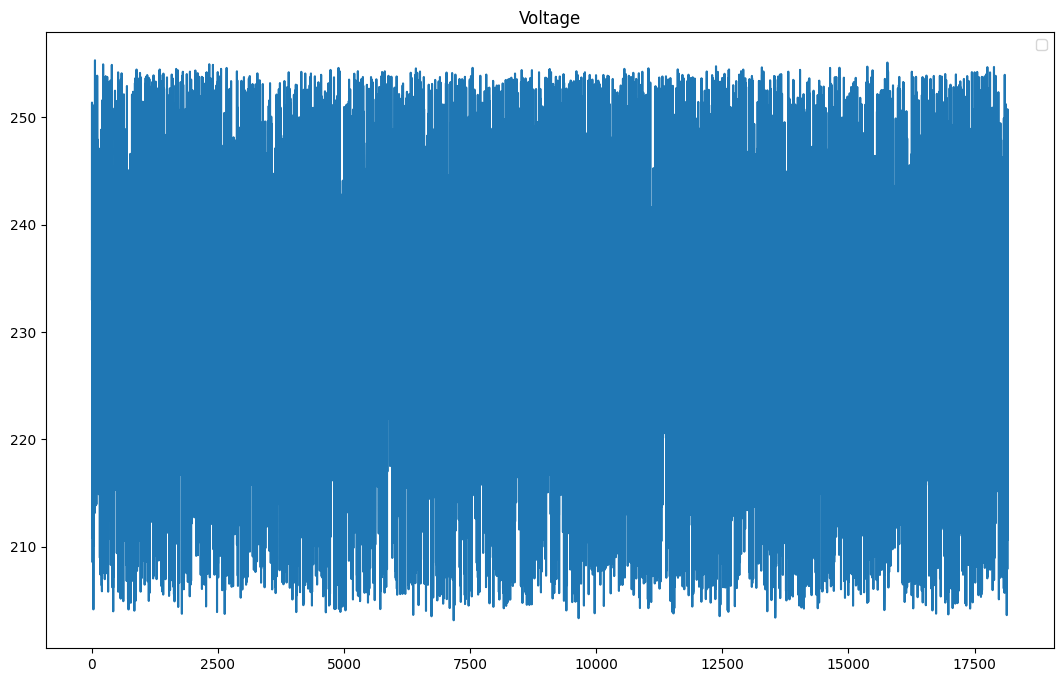

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


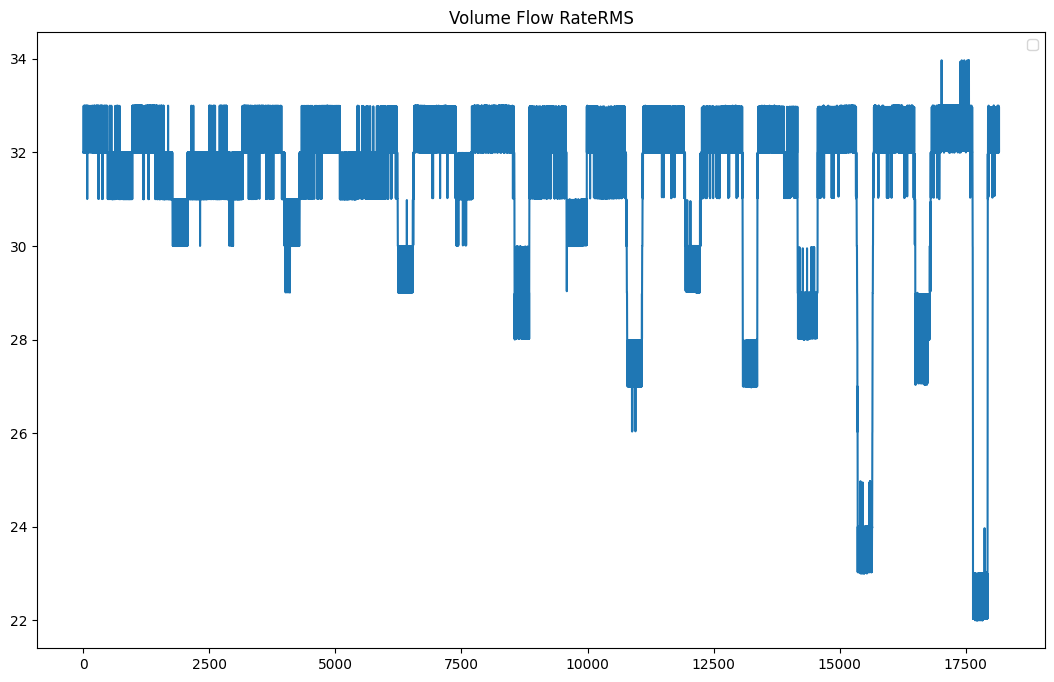

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


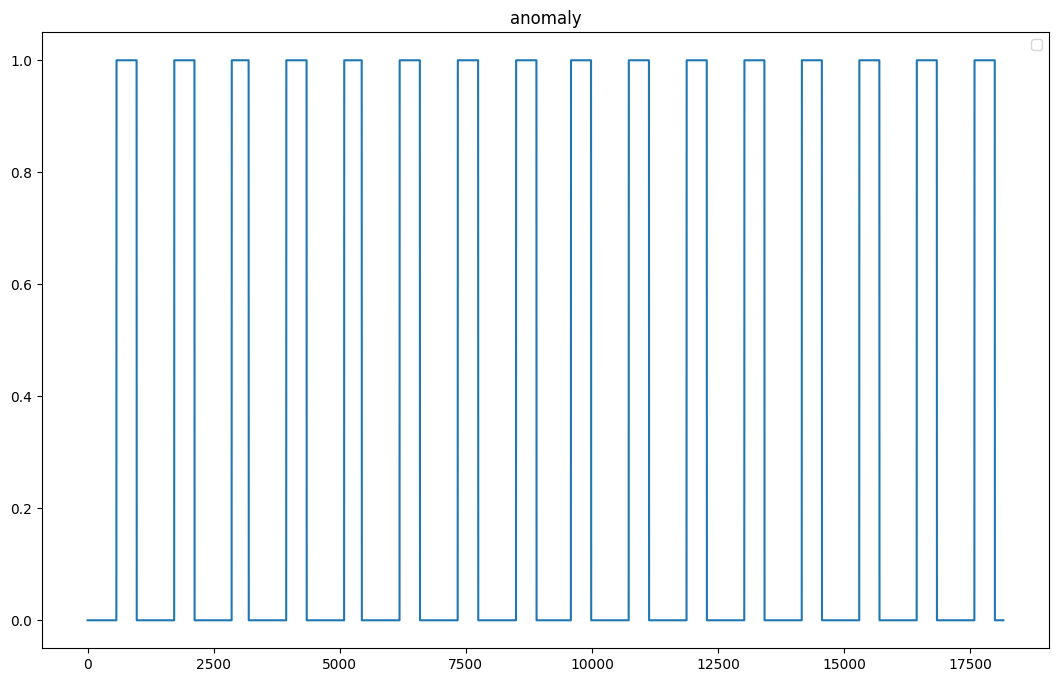

In [4]:
#TS data plotting(Change point is not use)

for column in valve1_data.columns[:-1]:
    plt.figure(figsize=(13,8))
    plt.plot(valve1_data[column].values)
    ax=plt.gca()
    
    plt.legend()
    plt.title(column)
    plt.show()

There are no missing values in valve1_data.

In [5]:
valve1_data.isnull().sum(axis=0)

Accelerometer1RMS      0
Accelerometer2RMS      0
Current                0
Pressure               0
Temperature            0
Thermocouple           0
Voltage                0
Volume Flow RateRMS    0
anomaly                0
changepoint            0
dtype: int64

**Correlation coefficient**

We examine the relation between the characteristics and the objective variable by using python seaborn.

For concretely, we make the heatmap of the correlation coefficient.

As a result, we found that having the strong negative correlation -0.62 between "Volume Flow RateRMS" and "anomaly".

<Axes: >

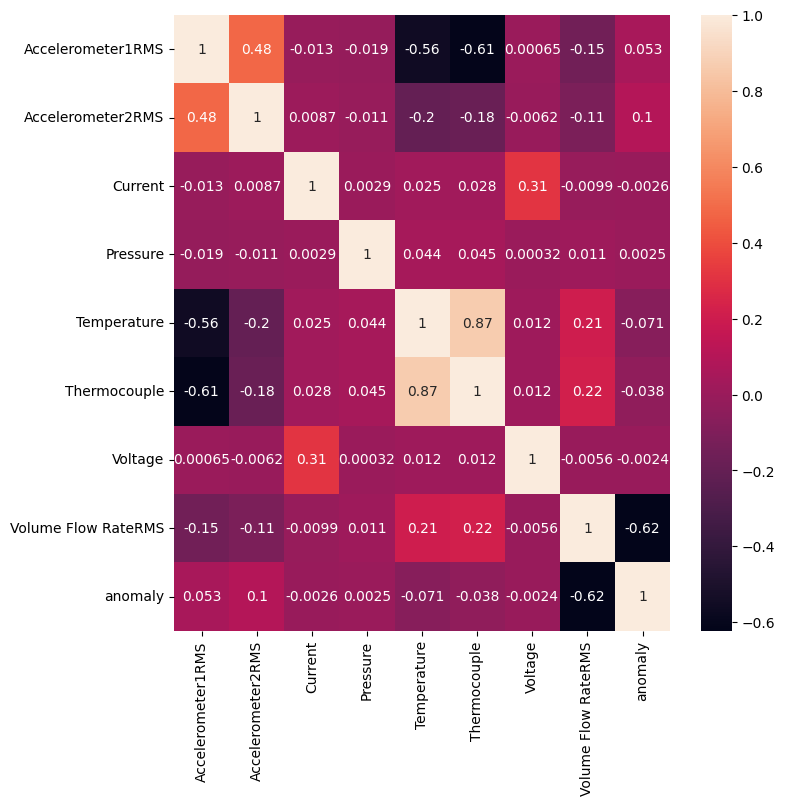

In [6]:
#Correlation coefficient
plt.figure(figsize=(8,8))
data=valve1_data.drop(columns='changepoint')
sns.heatmap(data.corr(),annot=True,fmt='.2g')

# 4. Data Pre-processing

We implement data pre-processing before the supervised learning.

**Divide into train,valid and test groups**

The context of TS data is important to predict the anomaly, so we don't use train_test_split() function. 

If you use this function, the data is mixed randomly and it leads to destroy the context. We divide the data like train:valid:test=7:2:1. 

In [7]:
#train_pre(valve1_data is dataframe)
train_pre=valve1_data

#train_pre ⇒ train:valid_pre=7:3
train_pre_size=len(train_pre)
train_size=int(train_pre_size*0.7)
train=train_pre[0:train_size]
x_train_pre=train.drop('anomaly',axis=1)
x_train=x_train_pre.drop('changepoint',axis=1)
y_train=train['anomaly'].values

#valid_pre ⇒ valid:test=2:1
valid_pre_size=train_pre_size-train_size
valid_size=int(valid_pre_size*0.66)
valid=train_pre[train_size:train_size+valid_size]
x_valid_pre=valid.drop('anomaly',axis=1)
x_valid=x_valid_pre.drop('changepoint',axis=1)
y_valid=valid['anomaly'].values

test=train_pre[train_size+valid_size:]
x_test_pre=test.drop('anomaly',axis=1)
x_test=x_test_pre.drop('changepoint',axis=1)
y_test=test['anomaly'].values

In [8]:
display(x_train)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0000
2020-03-09 10:14:34,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0000
2020-03-09 10:14:35,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0000
2020-03-09 10:14:36,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0000
2020-03-09 10:14:37,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 13:59:09,0.028142,0.039445,0.981651,0.382638,66.9901,24.7381,232.774,32.0000
2020-03-09 13:59:10,0.028283,0.040615,0.966102,0.054711,66.8982,24.7404,227.030,32.0226
2020-03-09 13:59:11,0.028778,0.041955,0.827491,-0.601143,66.8706,24.7499,228.784,32.9781


In [9]:
display(x_valid)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 13:59:14,0.027507,0.040703,1.303390,0.054711,66.9704,24.7351,230.644,32.9781
2020-03-09 13:59:15,0.027513,0.040440,1.134970,0.054711,67.0253,24.7351,216.261,32.0000
2020-03-09 13:59:16,0.027721,0.039620,1.319540,0.054711,66.9084,24.7379,231.529,32.0226
2020-03-09 13:59:17,0.028237,0.040403,1.353650,0.054711,66.8116,24.7443,253.006,32.9781
2020-03-09 13:59:18,0.028097,0.040630,1.413930,0.054711,66.8467,24.7357,224.342,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 15:02:15,0.026906,0.040246,1.131370,0.382638,68.3998,24.5080,234.733,32.0000
2020-03-09 15:02:16,0.026948,0.038869,1.397970,0.054711,68.4817,24.5268,212.247,32.0000
2020-03-09 15:02:17,0.026791,0.038432,0.717252,0.054711,68.4652,24.5268,239.494,32.0000


In [10]:
display(x_test)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 15:02:21,0.027773,0.039028,1.326890,0.054711,68.5600,24.5135,231.830,32.9709
2020-03-09 15:02:22,0.027711,0.039946,1.110150,0.054711,68.5861,24.5136,239.315,32.0000
2020-03-09 15:02:23,0.027657,0.040355,1.273900,0.710565,68.4256,24.5084,240.306,32.0300
2020-03-09 15:02:24,0.027274,0.039846,0.819551,0.054711,68.6263,24.5139,236.042,32.9709
2020-03-09 15:02:25,0.027238,0.039922,1.101930,0.054711,68.4726,24.5196,236.624,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 15:34:37,0.027605,0.039760,0.622996,0.382638,68.4247,24.4370,230.358,32.9673
2020-03-09 15:34:38,0.027286,0.039613,0.600692,0.054711,68.0598,24.4356,231.373,32.0000
2020-03-09 15:34:39,0.027203,0.041440,0.450323,0.054711,68.1836,24.4379,210.605,32.0337


We split the data into the normal class and the anomaly class for each data group(train group, valid group and test group).

When we plot histgrams for each characteristic, we found that all data group are distributed at almost same location.

It means that the train group are covered over the test group. So if we train the model precisely, the model which has the generalization performance can be obtained.

Also, the normal distribution and the anomaly distribution for each characteristic are not apart each other ,so it is not appropriate to construct model by using just one characteristic. 

Thus we use all characteristic and expect that using all characteristic leads to separativeness of 2 class :normal and anomaly.

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

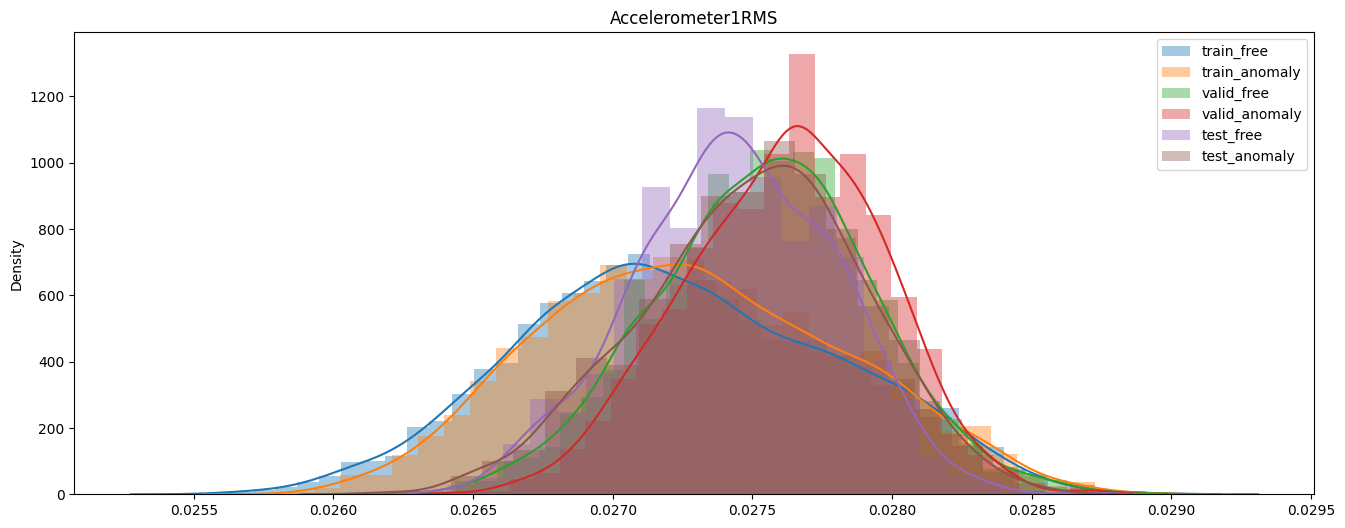

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

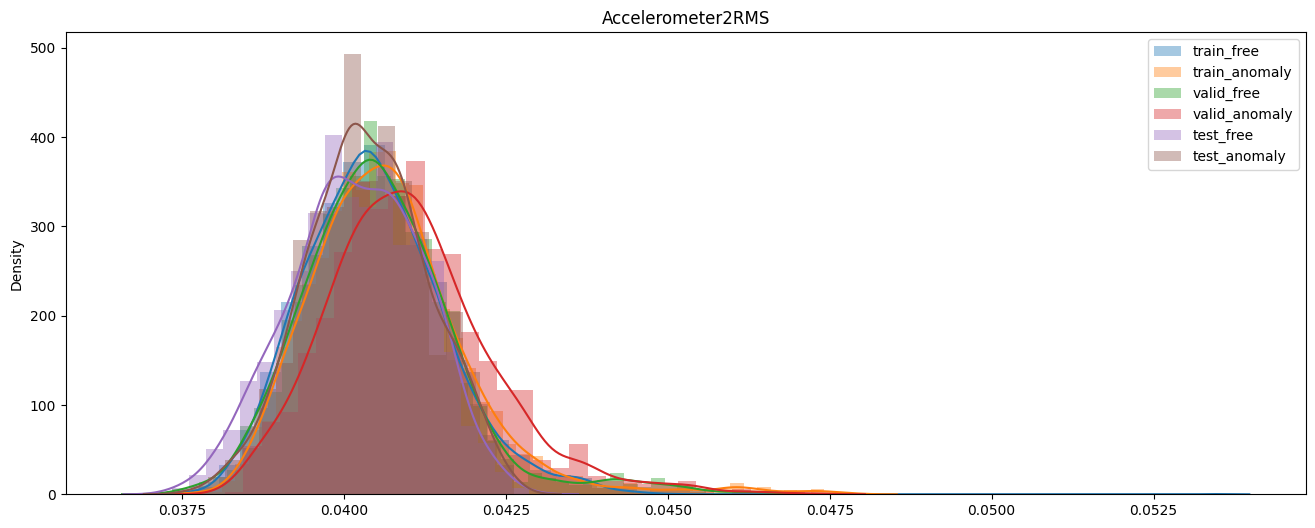

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

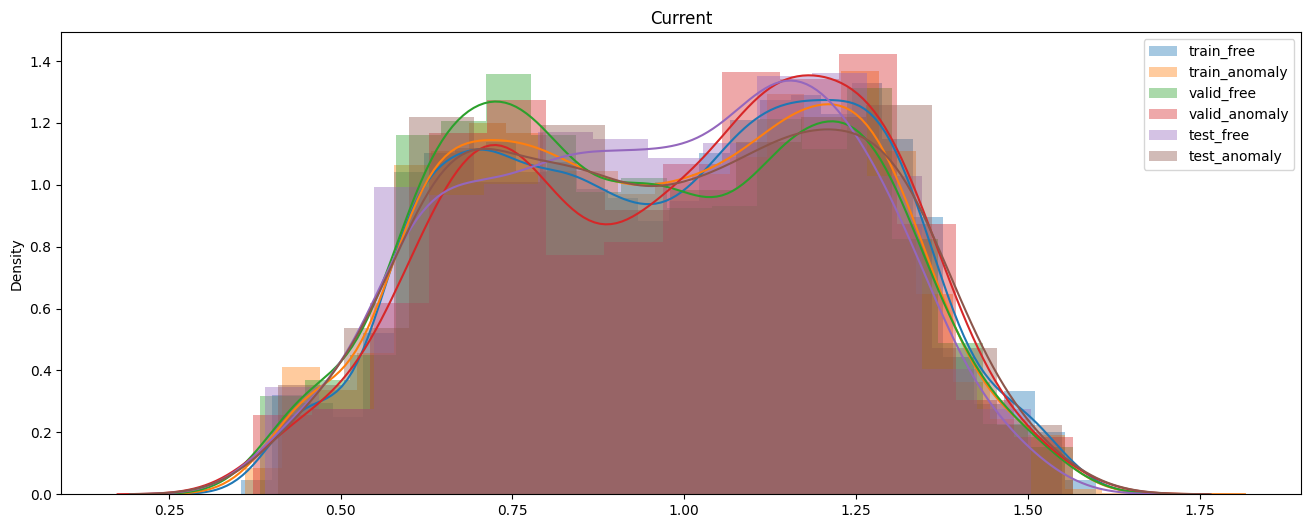

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

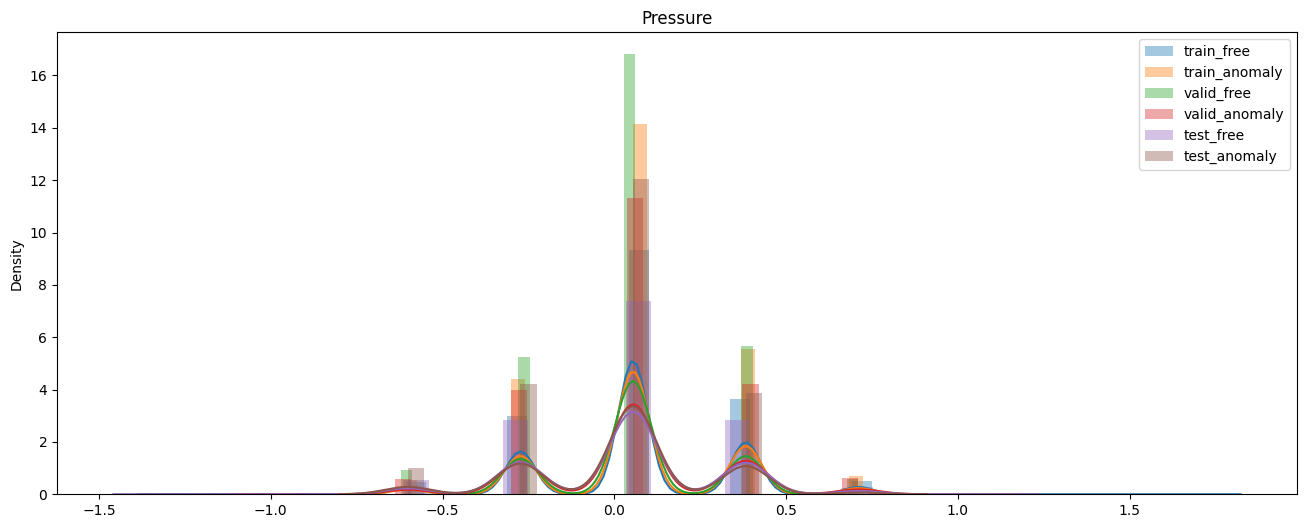

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

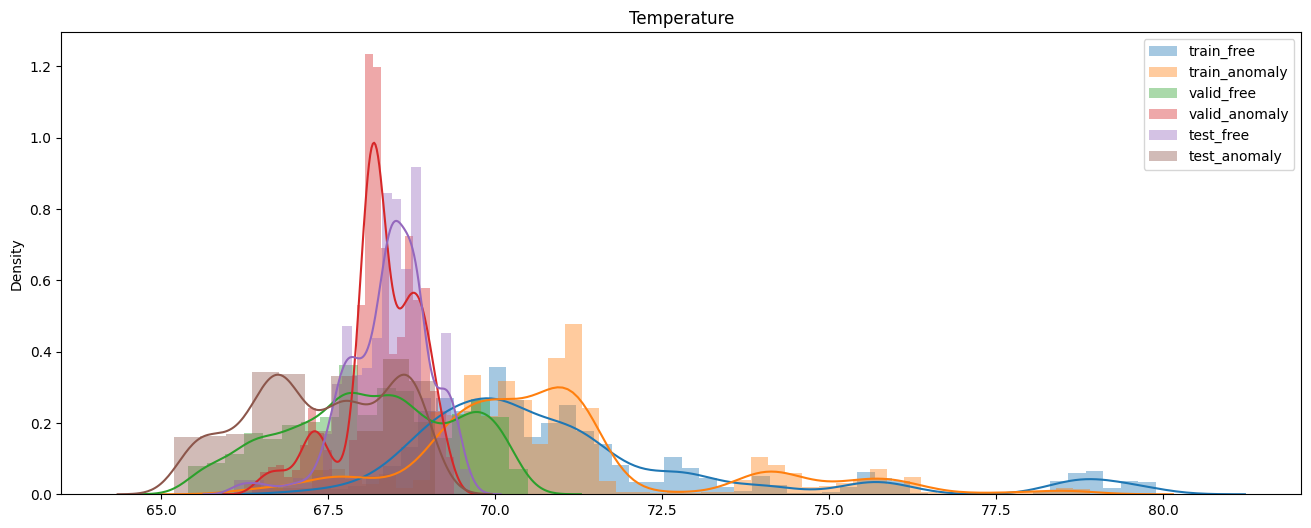

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

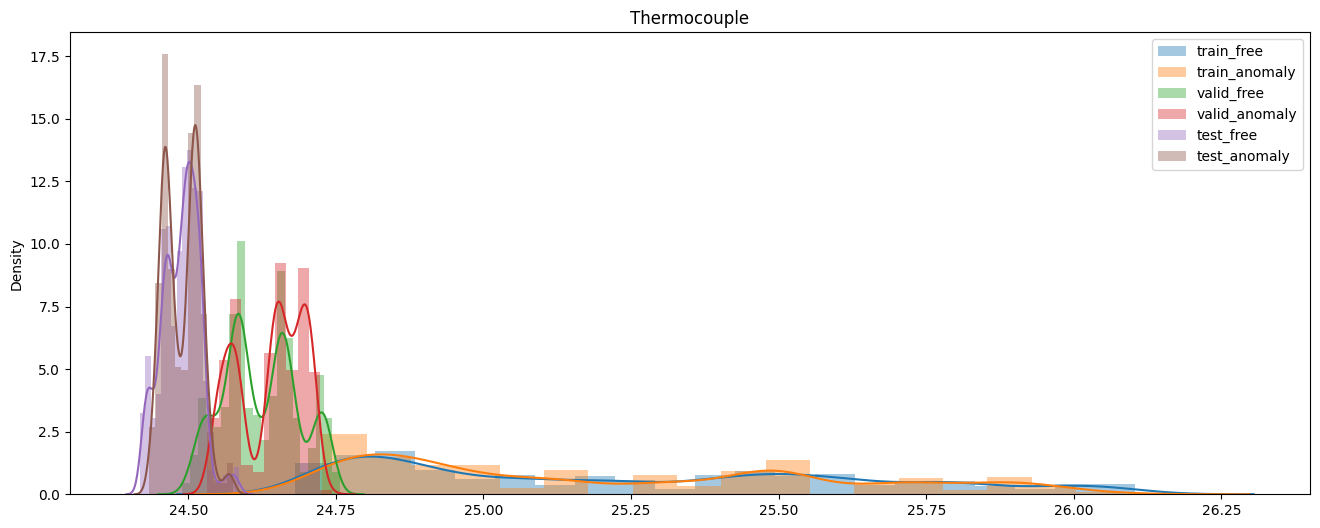

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

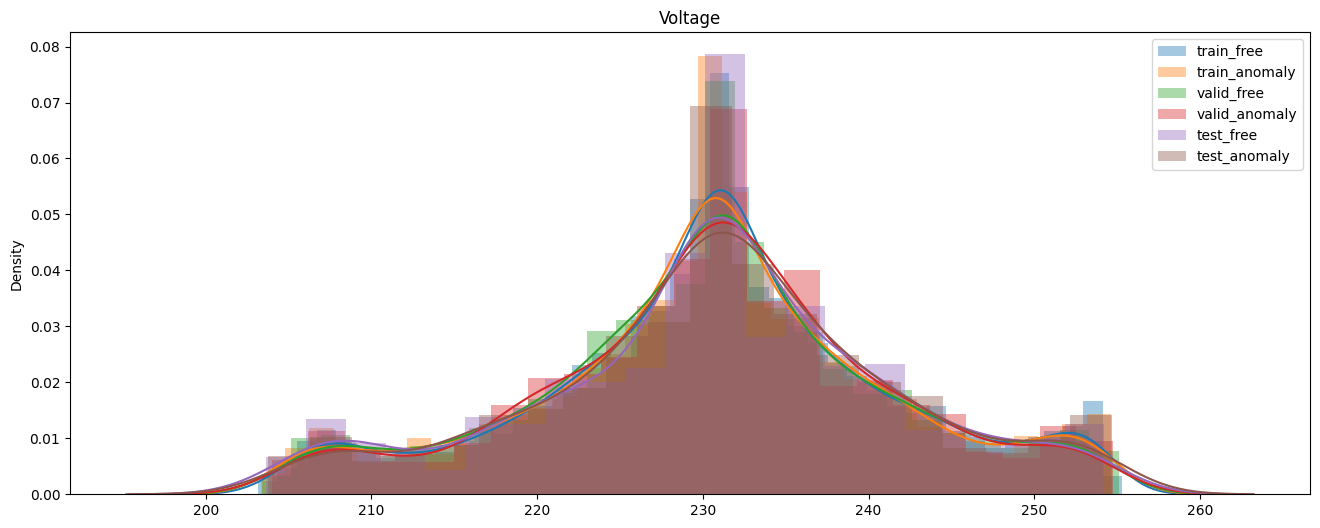

/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
/var/folders/k3/9_g2bn810b93x8c0jjjcy7bm0000gn/T/ipykernel_94866/4005518094.py:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

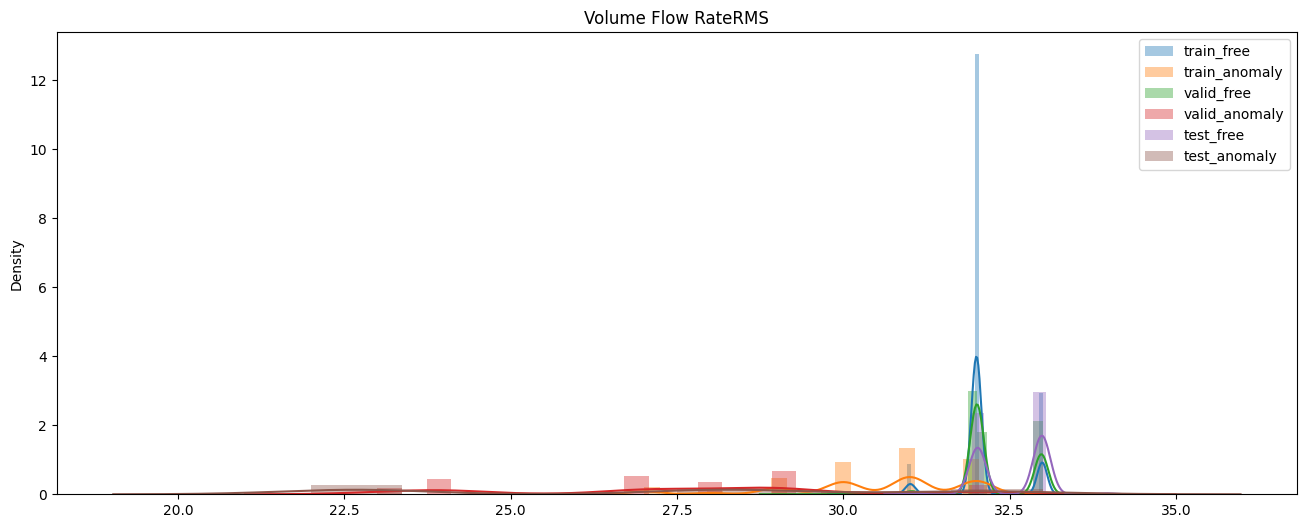

In [11]:
#*** split into free and anomaly ***
def free_anomaly_split(X,Y):
    free=[]
    anomaly=[]
    
    for x,y in zip(X,Y):
        if y==0:
            free.append(x)
        elif y==1:
            anomaly.append(x)
    
    free=np.array(free)
    anomaly=np.array(anomaly)
        
    return free,anomaly

x_train_free,x_train_anomaly=free_anomaly_split(x_train.values,y_train)
x_valid_free,x_valid_anomaly=free_anomaly_split(x_valid.values,y_valid)
x_test_free,x_test_anomaly=free_anomaly_split(x_test.values,y_test)

#histgram of normal and anomaly
features={1:'Accelerometer1RMS',2:'Accelerometer2RMS',3:'Current',4:'Pressure',5:'Temperature',6:'Thermocouple',7:'Voltage',8:'Volume Flow RateRMS'}
bins=None

for key,col in features.items():
    plt.figure(figsize=(16,6))
    sns.distplot(x_train_free[:,key-1],bins=bins,label='train_free')
    sns.distplot(x_train_anomaly[:,key-1],bins=bins,label='train_anomaly')
    sns.distplot(x_valid_free[:,key-1],bins=bins,label='valid_free')
    sns.distplot(x_valid_anomaly[:,key-1],bins=bins,label='valid_anomaly')
    sns.distplot(x_test_free[:,key-1],bins=bins,label='test_free')
    sns.distplot(x_test_anomaly[:,key-1],bins=bins,label='test_anomaly')   
    
    plt.title(col)
    plt.legend()
    plt.show()

**Data smoothing using Kaiser window**

TS data includes the residual error. If this error has large number, it is difficult to capture the meaning pattern from original TS data.

In this case, data smoothing is useful to cancel the residual. We choose Kaiser as the window function.

In [12]:
def smooth_curve(x):
    #x=1 dimension array
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

x_train_win=np.zeros_like(x_train.values)
x_valid_win=np.zeros_like(x_valid.values)
x_test_win=np.zeros_like(x_test.values)

data_dim=8
for i in range(0,data_dim):
    x_train_win[:,i]=smooth_curve(x_train.values[:,i].flatten())
    x_valid_win[:,i]=smooth_curve(x_valid.values[:,i].flatten())
    x_test_win[:,i]=smooth_curve(x_test.values[:,i].flatten())

We compare the TS data before and after data smoothing.

We can check that the residual error is cancel out almost. 
(Blue:TS data before data smoothing. Red:TS data after data smoothing)

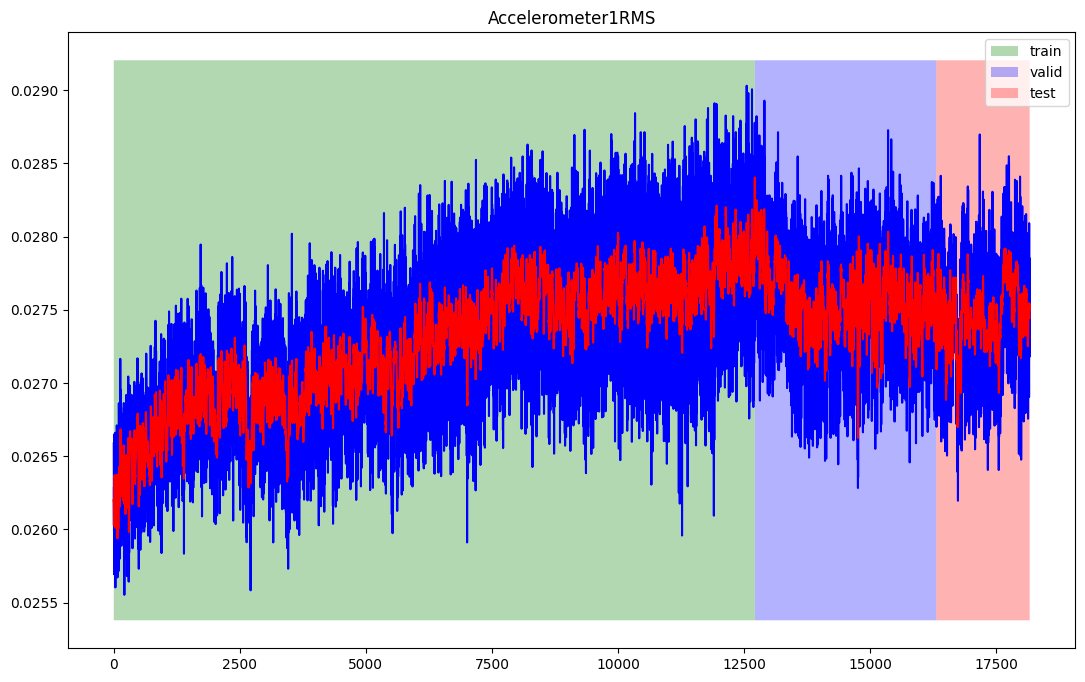

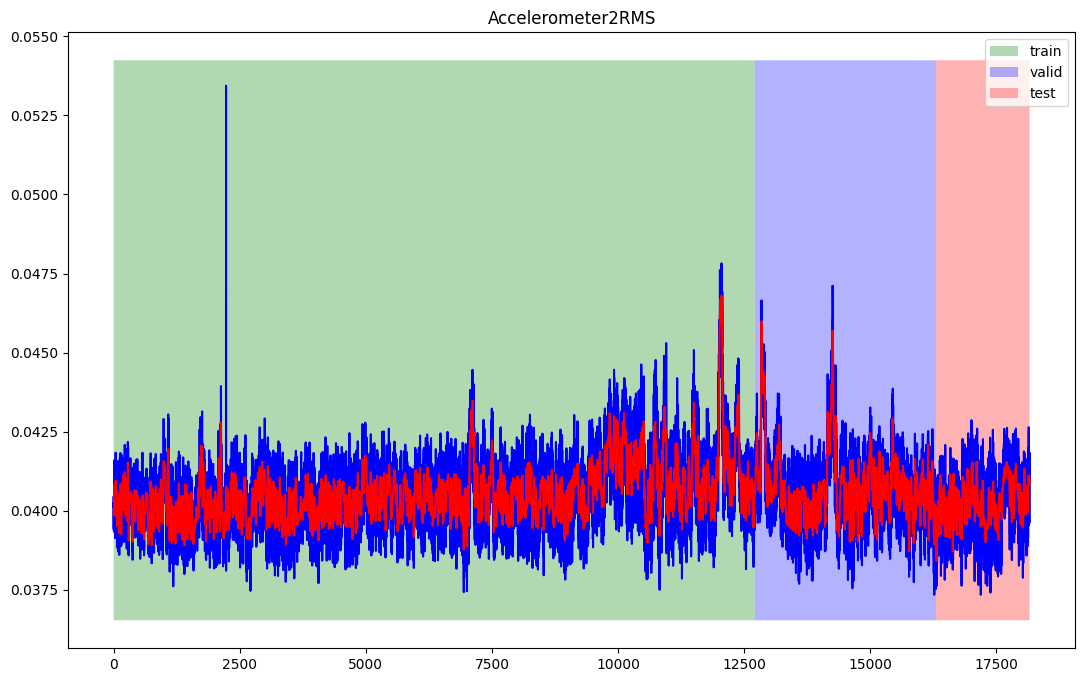

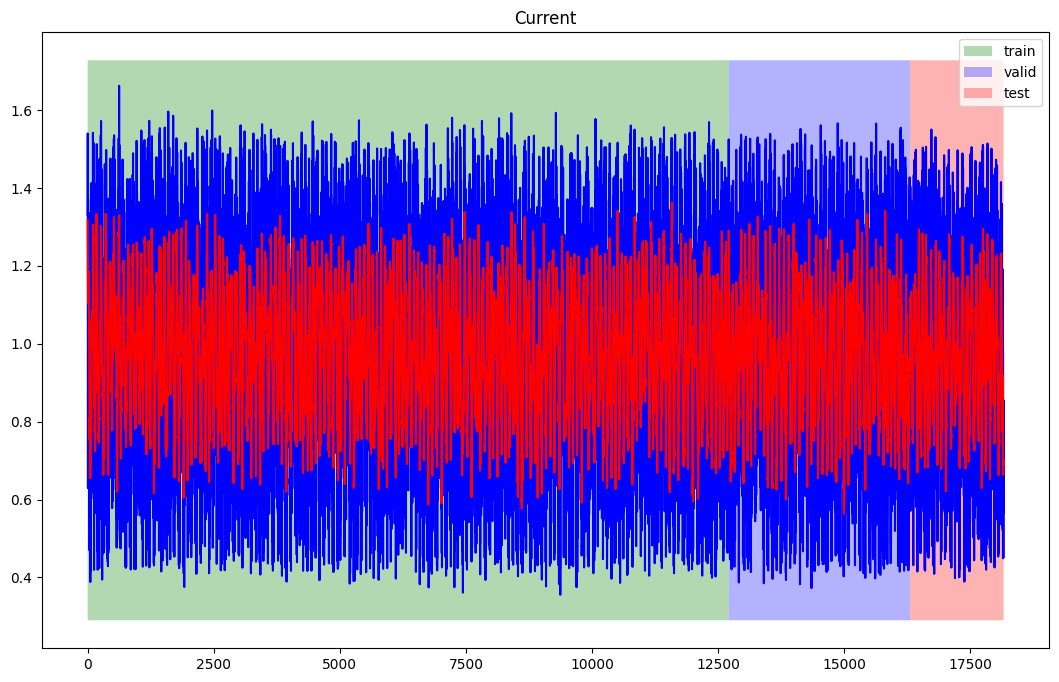

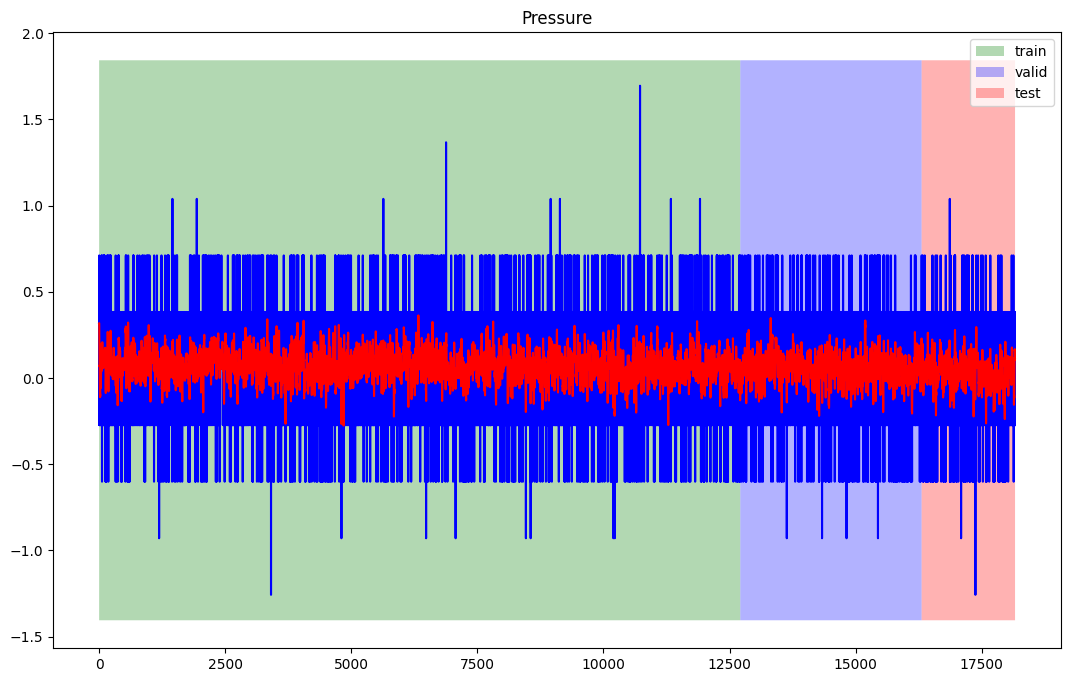

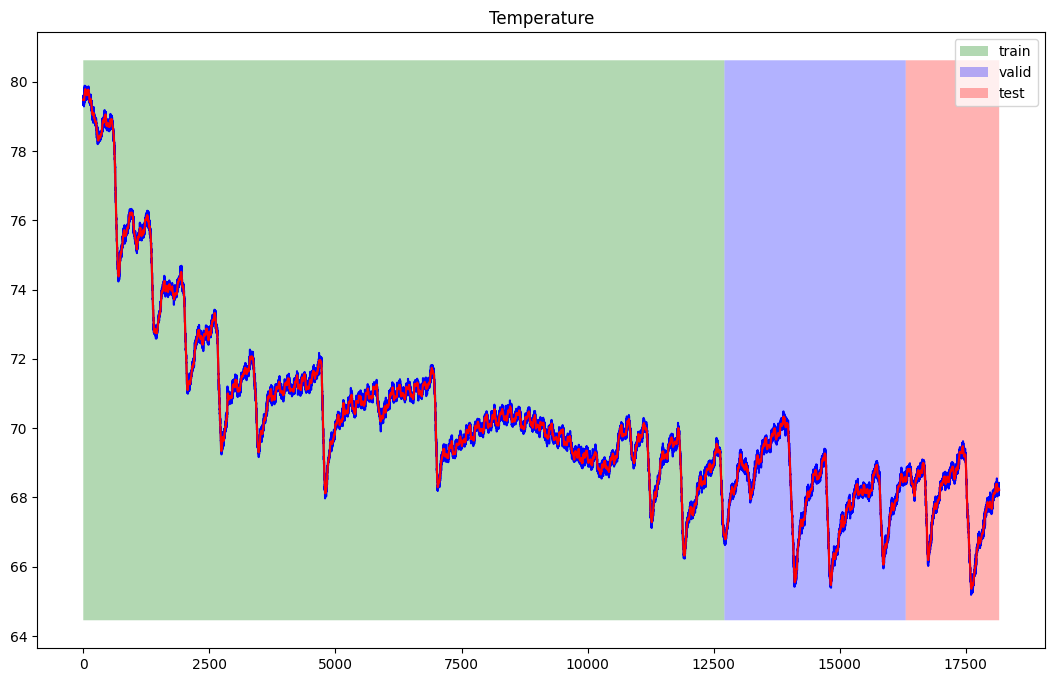

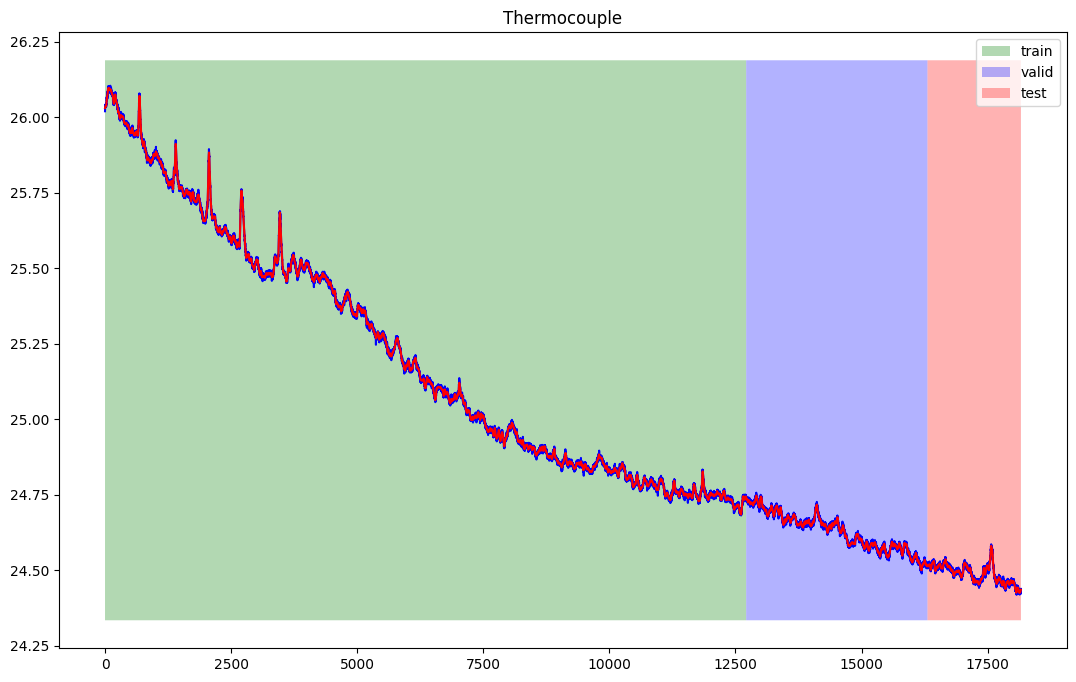

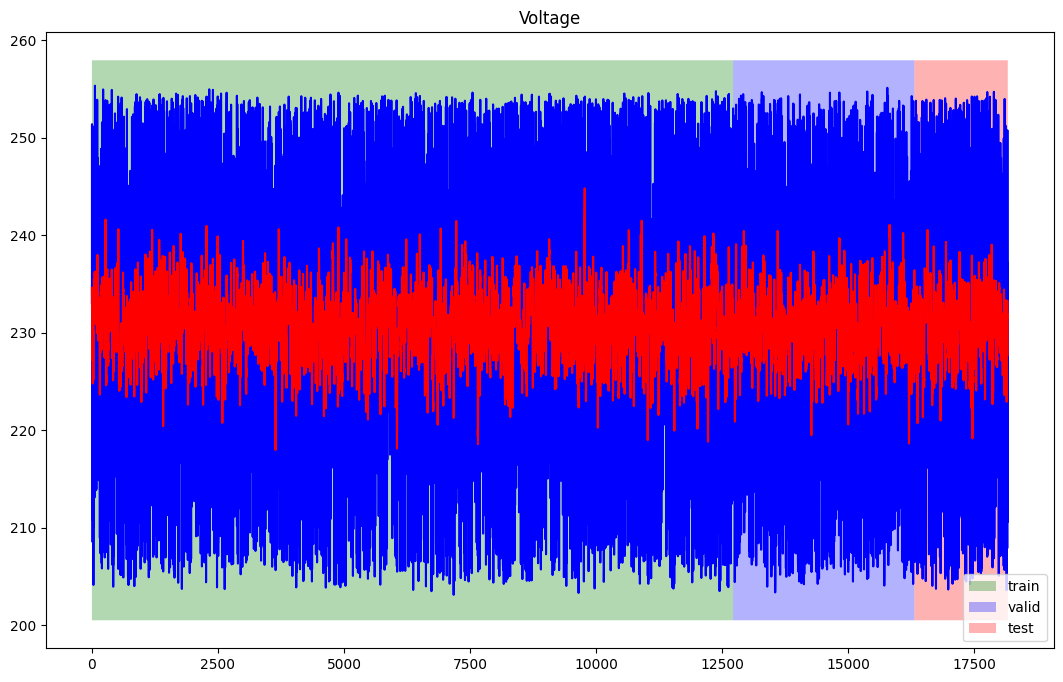

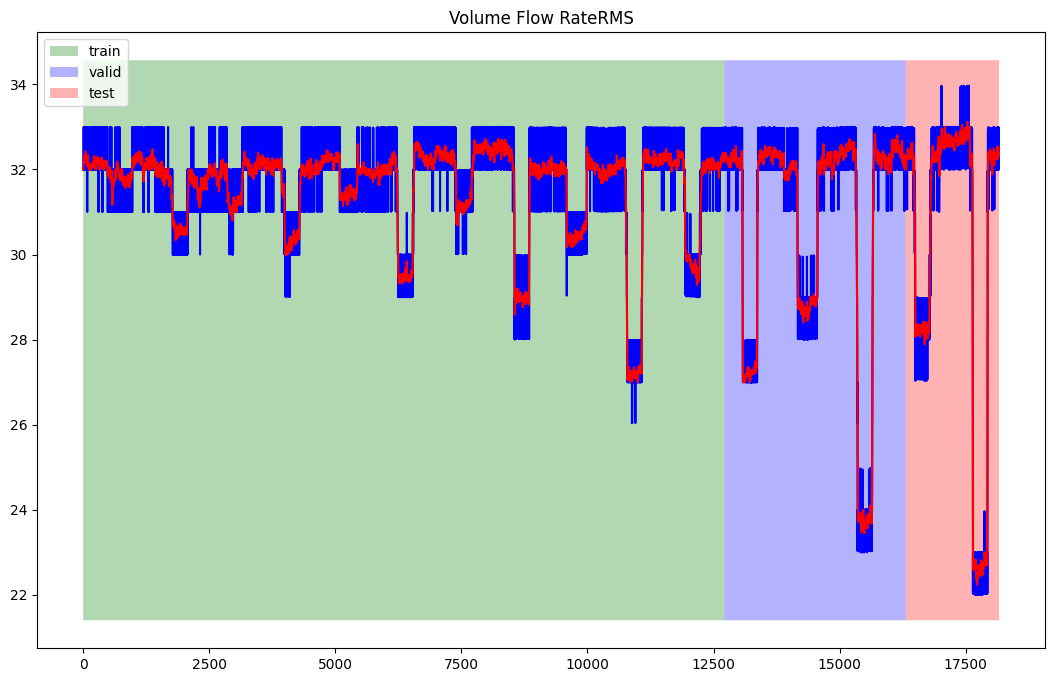

In [13]:
x1=np.arange(0,12713)
x2=np.arange(12713,16309)
x3=np.arange(16309,18162)

x_all_data=pd.concat([x_train,x_valid,x_test],ignore_index=False)

features=['Accelerometer1RMS','Accelerometer2RMS','Current','Pressure','Temperature','Thermocouple','Voltage','Volume Flow RateRMS']
mat=np.concatenate([x_train_win,x_valid_win,x_test_win],axis=0)

x_all_data_win=pd.DataFrame(mat,columns=features)

for column in x_all_data.columns[:]:
    plt.figure(figsize=(13,8))
    plt.plot(x_all_data[column].values,color='b')
    plt.plot(x_all_data_win[column].values,color='r')
    ax=plt.gca()
    y_min,y_max=ax.get_ylim()
    
    y1=[y_min]*len(x1)
    y2=[y_max]*len(x1)
    plt.fill_between(x1,y1,y2,facecolor='g',alpha=0.3,label='train')
    
    y1=[y_min]*len(x2)
    y2=[y_max]*len(x2)
    plt.fill_between(x2,y1,y2,facecolor='b',alpha=0.3,label='valid')
    
    y1=[y_min]*len(x3)
    y2=[y_max]*len(x3)
    plt.fill_between(x3,y1,y2,facecolor='r',alpha=0.3,label='test')
    
    plt.legend()
    plt.title(column)
    plt.show()

**Data Standardization**

We implement Z-standardization as data standardization to correct the scale difference of each characteristic.

In [14]:
from sklearn.preprocessing import StandardScaler

# Generate instance for standardization
sc = StandardScaler()

# Calculate the transform matrix and it is applied to valid and test data
x_train_std = sc.fit_transform(x_train_win)
x_valid_std = sc.transform(x_valid_win)
x_test_std = sc.transform(x_test_win)

In [15]:
x_train_std

array([[-2.468652  , -0.64544545,  1.91000275, ...,  2.02249423,
         1.10587393,  0.38495525],
       [-2.45105035, -0.68306452,  1.74471121, ...,  2.0236445 ,
         1.02036622,  0.38495525],
       [-2.51099832, -0.70616325,  1.61824091, ...,  2.02408394,
         0.7796727 ,  0.38495525],
       ...,
       [ 2.36661992,  0.14560175,  0.73433992, ..., -1.19329053,
         0.48272715,  0.63460574],
       [ 2.54791985,  0.25416161,  0.83770747, ..., -1.19273829,
         0.7853573 ,  0.63436377],
       [ 2.68028479,  0.3136214 ,  0.88648332, ..., -1.19236657,
         0.77444079,  0.62307726]])

# 5. LightGBM model for anomaly detection

We construct the LightGBM model to deal with 2 classification problem. 

I start by training the model and then fine tuning the hyper parameter like learning rate, max_depth etc.

Finally. we assess the generalization performance using test data.

**Data  processing for LightGBM**

We implement data processing appropriate for LightGBM model.

When we choose just one TS point as the explanatory variable, we can't reflect the context information of TS into model. 

It means the useless predict model.

So, we calculate the stats like mean, min and max within the window area, which is parameterized by look_back.

We assign these stats as the explanatory variable.

Also, we assign the class label at right end of window as the objective variable.

We set look_back=10.

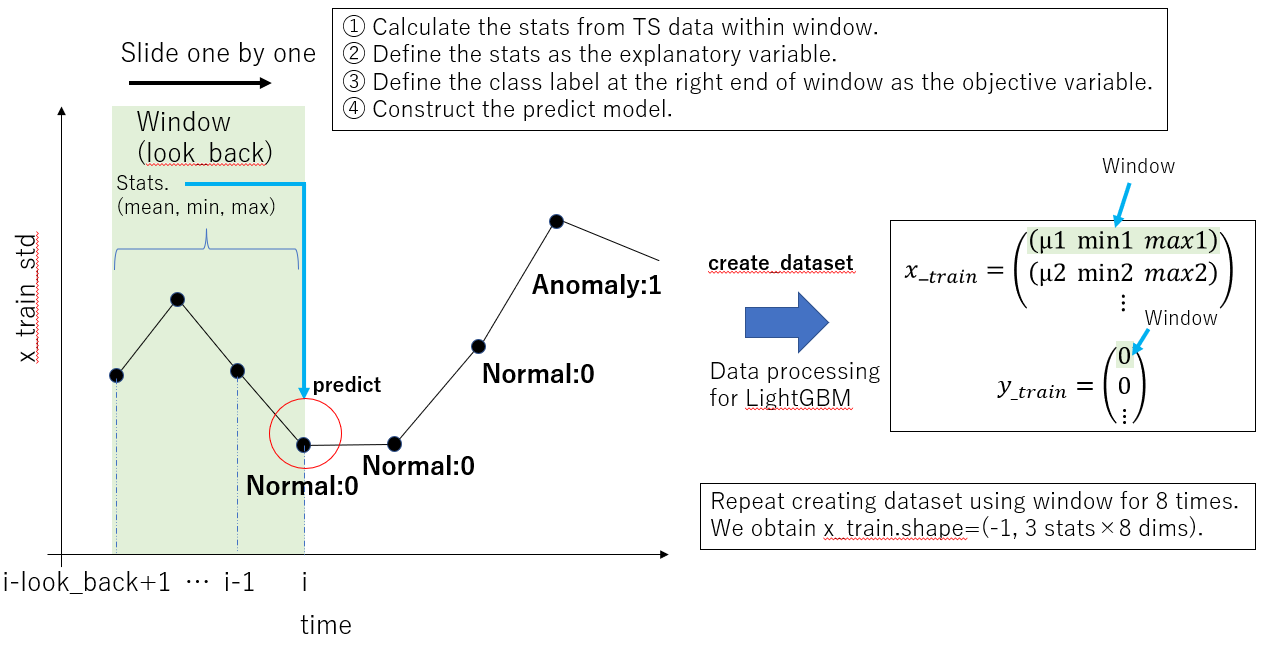

In [16]:
#create_dataset function
def create_dataset(dataset,look_back):
    
    data_X=np.zeros((len(dataset)-look_back+1,3))
    j=0
    
    for i in range(look_back-1,len(dataset)):
        
        data_pre=dataset[i-look_back+1:i+1,0]
    
        data_pre_mean=np.mean(data_pre,axis=0)
        data_pre_min=np.min(data_pre,axis=0)
        data_pre_max=np.max(data_pre,axis=0)
        
        data_X[j,:]=np.array([data_pre_mean,data_pre_min,data_pre_max])
        j+=1
    
    return np.array(data_X).reshape(-1,3)  

#window parameter
look_back=10

#Dimension of input data
data_dim=8

for i in range(0,data_dim):
    
    if i==0:
        #train data
        x_train_win=create_dataset(x_train_std[:,i].reshape(-1,1),look_back)
        #valid data
        x_valid_win=create_dataset(x_valid_std[:,i].reshape(-1,1),look_back)
        #test data
        x_test_win=create_dataset(x_test_std[:,i].reshape(-1,1),look_back) 
    else:
        #train data
        x_train_win=np.concatenate([x_train_win,create_dataset( \
                                  x_train_std[:,i].reshape(-1,1),look_back)],axis=-1)
        #valid data
        x_valid_win=np.concatenate([x_valid_win,create_dataset( \
                                  x_valid_std[:,i].reshape(-1,1),look_back)],axis=-1)
        #test data
        x_test_win=np.concatenate([x_test_win,create_dataset( \
                                  x_test_std[:,i].reshape(-1,1),look_back)],axis=-1)
        
#change the shape of data
train_x_win=x_train_win.reshape(-1,3*data_dim)
train_y=y_train[look_back-1:]

valid_x_win=x_valid_win.reshape(-1,3*data_dim)
valid_y=y_valid[look_back-1:]

test_x_win=x_test_win.reshape(-1,3*data_dim)
test_y=y_test[look_back-1:]

#change data type of _x_win from ndarray into dataframe to calculate the importance of characteristic.
features=['A1_mean','A1_min','A1_max', \
          'A2_mean','A2_min','A2_max', \
          'Cur_mean','Cur_min','Cur_max', \
          'Pre_mean','Pre_min','Pre_max', \
          'Temp_mean','Temp_min','Temp_max', \
          'Ther_mean','Ther_min','Ther_max', \
          'Vol_mean','Vol_min','Vol_max', \
          'Flow_mean','Flow_min','Flow_max']

train_x=pd.DataFrame(train_x_win,columns=features)
valid_x=pd.DataFrame(valid_x_win,columns=features)
test_x=pd.DataFrame(test_x_win,columns=features)

In [17]:
train_y.size

12703

In [18]:
display(train_x)

,A1_mean,A1_min,A1_max,A2_mean,A2_min,A2_max,Cur_mean,Cur_min,Cur_max,Pre_mean,...,Temp_max,Ther_mean,Ther_min,Ther_max,Vol_mean,Vol_min,Vol_max,Flow_mean,Flow_min,Flow_max
0,-2.679089,-2.864603,-2.451050,-0.692771,-0.766579,-0.560769,1.183536,0.717977,1.910003,1.620684,...,3.285620,2.030184,2.022494,2.037442,-0.071078,-1.015900,1.105874,0.415241,0.384955,0.484738
1,-2.699031,-2.864603,-2.451050,-0.671595,-0.766579,-0.433684,1.078818,0.717977,1.744711,1.330048,...,3.285620,2.031622,2.023645,2.037442,-0.261791,-1.015900,1.020366,0.426118,0.384955,0.493729
2,-2.707403,-2.864603,-2.510998,-0.634787,-0.766579,-0.314984,1.001878,0.717977,1.618241,0.992338,...,3.285620,2.032984,2.024084,2.037442,-0.414315,-1.015900,0.779673,0.437308,0.384955,0.496849
3,-2.696253,-2.864603,-2.399500,-0.577142,-0.766579,-0.129719,0.955057,0.717977,1.347916,0.642981,...,3.285620,2.034259,2.025584,2.037442,-0.540164,-1.015900,0.304761,0.453079,0.384955,0.542672
4,-2.663400,-2.864603,-2.256516,-0.507201,-0.766579,-0.021372,0.933848,0.717977,1.150024,0.328982,...,3.285620,2.035386,2.029125,2.037442,-0.641341,-1.015900,-0.163899,0.469901,0.384955,0.553171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12698,1.449042,1.160086,1.917869,-0.372486,-0.642873,-0.116757,0.150692,-0.048238,0.322780,0.011702,...,-1.621160,-1.195173,-1.196945,-1.193388,0.377772,-0.230737,1.126148,0.631102,0.562738,0.682178
12699,1.538821,1.160086,2.085489,-0.311198,-0.586920,-0.029992,0.181942,-0.048238,0.615535,-0.118140,...,-1.626537,-1.195265,-1.196945,-1.193388,0.287082,-0.230737,0.903692,0.634523,0.583113,0.682178
12700,1.657042,1.160086,2.366620,-0.237946,-0.549500,0.145602,0.223098,-0.048238,0.734340,-0.374130,...,-1.630135,-1.195255,-1.196945,-1.193291,0.244985,-0.230737,0.820233,0.639672,0.594817,0.682178
12701,1.795825,1.250448,2.547920,-0.157580,-0.460490,0.254162,0.285773,-0.048238,0.837707,-0.640437,...,-1.634771,-1.195158,-1.196945,-1.192738,0.241498,-0.230737,0.785357,0.643627,0.596950,0.682178


**Training and fine-tuning**

First of all, we define LightGBM train predict function. We introduce the test_flag as argument for switching train and predict.
We set early_stopping_rounds=20 to avoid overfitting.

If test_flag = True (test mode), the function returns the accuracy, f1score, confusion matrix for test data and learned model.

If test_flag = False (training mode), it returns the accuracy for train data and valid data.

In [19]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf

# fix random seed
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = "0"
MODEL_TH = 0.8

#LightGBM train predict function
def lgb_train_predict(x_train,y_train,x_valid,y_valid,x_test,y_test,params, \
                      test_flag=False):
    
    lgb_train=lgb.Dataset(x_train,y_train)
    lgb_valid=lgb.Dataset(x_valid,y_valid)
    lgb_test=lgb.Dataset(x_test,y_test)
    
    model_lgb=lgb.train(params=params,train_set=lgb_train, \
                        valid_sets=[lgb_train,lgb_valid], \
                        )
    
    if test_flag:
        test_pred=np.zeros((len(y_test),1))
        test_pred[:,0]=np.where(model_lgb.predict(x_test)>=MODEL_TH,1,0)
        test_acc=accuracy_score(y_test.reshape(-1,1),test_pred)
        test_f1score=f1_score(y_test.reshape(-1,1),test_pred)
        test_cm=confusion_matrix(y_test.reshape(-1,1),test_pred)
        
        return test_acc,test_f1score,test_cm,test_pred,model_lgb
    
    else:
        train_pred=np.zeros((len(y_train),1))
        train_pred[:,0]=np.where(model_lgb.predict(x_train)>=MODEL_TH,1,0)
        train_acc=accuracy_score(y_train.reshape(-1,1),train_pred)
        
        valid_pred=np.zeros((len(y_valid),1))
        valid_pred[:,0]=np.where(model_lgb.predict(x_valid)>=MODEL_TH,1,0)
        valid_acc=accuracy_score(y_valid.reshape(-1,1),valid_pred) 
        valid_cm=confusion_matrix(y_valid.reshape(-1,1),valid_pred)
        
        return train_acc,valid_acc, valid_cm

2024-02-06 12:41:32.784806: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We train the model using the training data(train_x,train_y).

This model needs to be fine-tunned for hyper paramter, so we optimize using the valid_data(valid_x,valid_y).

We implement 100 times random search method for optimizing hyper parameters. 

In [20]:
train_y

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
# Ramdom search for hyper parameter
optimization_trial = 100

results_val_acc = {}
results_train_acc= {}

for _ in range(optimization_trial):
    # =====the searching area of hyper parameter =====
    lr = 10 ** np.random.uniform(-3, 0)
    min_data_in_leaf=np.random.choice(range(1,21),1)[0]
    max_depth=np.random.choice(range(3,31),1)[0]
    num_leaves=np.random.choice(range(20,41),1)[0]
    # ================================================
    
    #Hyper parameter
    lgb_params={'objective':'binary',
                'metric':'binary_error',
                'force_row_wise':True,
                'seed':0,
                'learning_rate':lr,
                'min_data_in_leaf':min_data_in_leaf,
                'max_depth':max_depth,
                'num_leaves':num_leaves
               }

    train_acc,valid_acc, valid_cm  =lgb_train_predict(train_x,train_y,valid_x,valid_y,test_x,test_y,params=lgb_params,test_flag=False)
    print('optimization'+str(len(results_val_acc)+1))
    print("train acc:" + str(train_acc) + "valid acc:" + str(valid_acc) + " | lr:" + str(lr) + ", min_data_in_leaf:" + str(min_data_in_leaf) + \
          ",max_depth:" + str(max_depth) + ",num_leaves:" + str(num_leaves))
    key = " lr:" + str(lr) + ", min_data_in_leaf:" + str(min_data_in_leaf) + ", max_depth:" + str(max_depth) + ",num_leaves:" + str(num_leaves)
    results_val_acc[key] = valid_acc
    results_train_acc[key] = train_acc
    print('valid_confusionMatrix')
    display(valid_cm)

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization1
train acc:0.9681964890183421valid acc:0.9562186279977691 | lr:0.04430375245218265, min_data_in_leaf:1,max_depth:6,num_leaves:23
valid_confusionMatrix


array([[2376,   13],
       [ 144, 1053]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2364,   25],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization3
train acc:0.966779500905298valid acc:0.956776352481874 | lr:0.020547625125911337, min_data_in_leaf:7,max_depth:27,num_leaves:32
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization4
train acc:0.957175470361332valid acc:0.9564974902398216 | lr:0.014135935551752292, min_data_in_leaf:7,max_depth:10,num_leaves:34
valid_confusionMatrix


array([[2376,   13],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization5
train acc:0.9973234668975832valid acc:0.9573340769659788 | lr:0.05059803874660431, min_data_in_leaf:6,max_depth:28,num_leaves:33
valid_confusionMatrix


array([[2376,   13],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization6
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.01028462547983763, min_data_in_leaf:20,max_depth:19,num_leaves:39
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2331,   58],
       [ 138, 1059]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2369,   20],
       [ 137, 1060]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
optimization9
train acc:0.9600881681492561valid acc:0.9562186279977691 | lr:0.10880242882938454, min_data_in_leaf:8,max_depth:3,num_leaves:21
valid_confusionMatrix


array([[2375,   14],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization10
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.00269190582492607, min_data_in_leaf:1,max_depth:13,num_leaves:40
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization11
train acc:0.9601668897110919valid acc:0.9570552147239264 | lr:0.026351252231361928, min_data_in_leaf:12,max_depth:21,num_leaves:22
valid_confusionMatrix


array([[2376,   13],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization12
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0025448050634013252, min_data_in_leaf:5,max_depth:24,num_leaves:25
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization13
train acc:0.9973234668975832valid acc:0.9545454545454546 | lr:0.06859416411328695, min_data_in_leaf:18,max_depth:18,num_leaves:24
valid_confusionMatrix


array([[2376,   13],
       [ 150, 1047]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2369,   20],
       [ 143, 1054]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization15
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0015159204611384708, min_data_in_leaf:4,max_depth:9,num_leaves:31
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization16
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.004277083049962071, min_data_in_leaf:1,max_depth:17,num_leaves:23
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization17
train acc:0.9267102259308825valid acc:0.9562186279977691 | lr:0.012334805700860013, min_data_in_leaf:11,max_depth:23,num_leaves:31
valid_confusionMatrix


array([[2376,   13],
       [ 144, 1053]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves

array([[2375,   14],
       [ 139, 1058]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization19
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.003047393617736387, min_data_in_leaf:5,max_depth:23,num_leaves:28
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization20
train acc:0.9635519168700307valid acc:0.956776352481874 | lr:0.01750272884486083, min_data_in_leaf:4,max_depth:29,num_leaves:35
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization21
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0021435095535798543, min_data_in_leaf:17,max_depth:20,num_leaves:25
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization22
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.003888186473153667, min_data_in_leaf:1,max_depth:8,num_leaves:20
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2376,   13],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2263,  126],
       [ 138, 1059]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization25
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0014694136880098081, min_data_in_leaf:10,max_depth:3,num_leaves:30
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization26
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.007053763390632227, min_data_in_leaf:3,max_depth:28,num_leaves:22
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2375,   14],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization28
train acc:0.9971660237739117valid acc:0.9570552147239264 | lr:0.05009615137983935, min_data_in_leaf:18,max_depth:21,num_leaves:34
valid_confusionMatrix


array([[2376,   13],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization29
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0019134694478070968, min_data_in_leaf:2,max_depth:7,num_leaves:30
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization30
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.006810134414375388, min_data_in_leaf:9,max_depth:14,num_leaves:22
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization31
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0024853845095262, min_data_in_leaf:1,max_depth:25,num_leaves:20
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization32
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.006225733021242983, min_data_in_leaf:15,max_depth:13,num_leaves:39
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization33
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0011490069048873189, min_data_in_leaf:9,max_depth:16,num_leaves:22
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization34
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.006456897906217104, min_data_in_leaf:3,max_depth:14,num_leaves:33
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization35
train acc:0.9592222309690625valid acc:0.956776352481874 | lr:0.019946384472763177, min_data_in_leaf:9,max_depth:22,num_leaves:28
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2376,   13],
       [ 150, 1047]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization37
train acc:0.9676454380854916valid acc:0.9573340769659788 | lr:0.022263488451764367, min_data_in_leaf:4,max_depth:16,num_leaves:31
valid_confusionMatrix


array([[2376,   13],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization38
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.007803884850277907, min_data_in_leaf:14,max_depth:28,num_leaves:33
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization39
train acc:1.0valid acc:0.9551031790295594 | lr:0.10624713883091959, min_data_in_leaf:17,max_depth:27,num_leaves:34
valid_confusionMatrix


array([[2376,   13],
       [ 148, 1049]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2376,   13],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization41
train acc:0.9635519168700307valid acc:0.956776352481874 | lr:0.01868809984193789, min_data_in_leaf:7,max_depth:24,num_leaves:33
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization42
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.007310936521630819, min_data_in_leaf:16,max_depth:12,num_leaves:38
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2364,   25],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization44
train acc:0.9971660237739117valid acc:0.9564974902398216 | lr:0.05127370874628439, min_data_in_leaf:2,max_depth:25,num_leaves:32
valid_confusionMatrix


array([[2375,   14],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2310,   79],
       [ 139, 1058]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization46
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.002653332733131654, min_data_in_leaf:13,max_depth:9,num_leaves:23
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

array([[2365,   24],
       [ 137, 1060]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization48
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.001998391905573771, min_data_in_leaf:9,max_depth:23,num_leaves:30
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization49
train acc:0.9688262615130284valid acc:0.9573340769659788 | lr:0.025570988797875227, min_data_in_leaf:6,max_depth:18,num_leaves:28
valid_confusionMatrix


array([[2376,   13],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization50
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0030724074111466446, min_data_in_leaf:20,max_depth:28,num_leaves:39
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2334,   55],
       [ 139, 1058]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization52
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.001612504689638591, min_data_in_leaf:10,max_depth:26,num_leaves:23
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization53
train acc:0.9554435960009446valid acc:0.9461795872838817 | lr:0.01820648507180312, min_data_in_leaf:19,max_depth:15,num_leaves:23
valid_confusionMatrix


array([[2339,   50],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2343,   46],
       [ 136, 1061]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization55
train acc:1.0valid acc:0.9564974902398216 | lr:0.1971220000597586, min_data_in_leaf:2,max_depth:15,num_leaves:22
valid_confusionMatrix


array([[2376,   13],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization56
train acc:0.9729197827284893valid acc:0.956776352481874 | lr:0.03656872500508881, min_data_in_leaf:2,max_depth:8,num_leaves:28
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization57
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.003455180839990765, min_data_in_leaf:1,max_depth:14,num_leaves:22
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization58
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.004696497161394395, min_data_in_leaf:17,max_depth:11,num_leaves:21
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization59
train acc:1.0valid acc:0.956776352481874 | lr:0.22435344153433004, min_data_in_leaf:4,max_depth:27,num_leaves:28
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization60
train acc:1.0valid acc:0.9562186279977691 | lr:0.12511063378806395, min_data_in_leaf:17,max_depth:28,num_leaves:23
valid_confusionMatrix


array([[2376,   13],
       [ 144, 1053]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization61
train acc:0.9997638353144926valid acc:0.9576129392080313 | lr:0.06948608894272314, min_data_in_leaf:4,max_depth:21,num_leaves:37
valid_confusionMatrix


array([[2375,   14],
       [ 138, 1059]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization62
train acc:0.9525308982130205valid acc:0.8798103736754044 | lr:0.7824728966705544, min_data_in_leaf:18,max_depth:23,num_leaves:22
valid_confusionMatrix


array([[2107,  282],
       [ 149, 1048]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization63
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.003618920291309287, min_data_in_leaf:13,max_depth:15,num_leaves:22
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

array([[2358,   31],
       [ 138, 1059]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization65
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0014765732560531632, min_data_in_leaf:18,max_depth:9,num_leaves:27
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization66
train acc:1.0valid acc:0.9570552147239264 | lr:0.12275253409866281, min_data_in_leaf:12,max_depth:22,num_leaves:37
valid_confusionMatrix


array([[2376,   13],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization67
train acc:0.9890577029048256valid acc:0.956776352481874 | lr:0.04241273949596576, min_data_in_leaf:15,max_depth:24,num_leaves:29
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization68
train acc:1.0valid acc:0.9570552147239264 | lr:0.10918885718097318, min_data_in_leaf:1,max_depth:30,num_leaves:29
valid_confusionMatrix


array([[2376,   13],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization69
train acc:0.9891364244666614valid acc:0.9545454545454546 | lr:0.06624226646887021, min_data_in_leaf:18,max_depth:12,num_leaves:20
valid_confusionMatrix


array([[2376,   13],
       [ 150, 1047]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization70
train acc:0.960481775958435valid acc:0.956776352481874 | lr:0.023336937852100444, min_data_in_leaf:17,max_depth:13,num_leaves:24
valid_confusionMatrix


array([[2376,   13],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization71
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0011533284318779018, min_data_in_leaf:4,max_depth:22,num_leaves:28
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization72
train acc:0.9981894040777769valid acc:0.9559397657557167 | lr:0.08656728470174353, min_data_in_leaf:15,max_depth:26,num_leaves:20
valid_confusionMatrix


array([[2376,   13],
       [ 145, 1052]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2375,   14],
       [ 136, 1061]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2355,   34],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2370,   19],
       [ 138, 1059]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2308,   81],
       [ 144, 1053]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization77
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0028912318204657684, min_data_in_leaf:14,max_depth:8,num_leaves:20
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization78
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.004412068131729174, min_data_in_leaf:16,max_depth:24,num_leaves:31
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2374,   15],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization80
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0024900285064657587, min_data_in_leaf:18,max_depth:30,num_leaves:39
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization81
train acc:0.9585137369125404valid acc:0.9439486893474623 | lr:0.024516055732776224, min_data_in_leaf:19,max_depth:24,num_leaves:22
valid_confusionMatrix


array([[2330,   59],
       [ 142, 1055]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization82
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.002719839508265555, min_data_in_leaf:12,max_depth:26,num_leaves:38
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization83
train acc:1.0valid acc:0.9573340769659788 | lr:0.17417375729910842, min_data_in_leaf:2,max_depth:9,num_leaves:30
valid_confusionMatrix


array([[2376,   13],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization84
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0017793742700293234, min_data_in_leaf:17,max_depth:29,num_leaves:23
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization85
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.007523892475314567, min_data_in_leaf:11,max_depth:12,num_leaves:32
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization86
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0015456632066963682, min_data_in_leaf:7,max_depth:9,num_leaves:27
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization87
train acc:1.0valid acc:0.9562186279977691 | lr:0.10227032587087773, min_data_in_leaf:8,max_depth:19,num_leaves:35
valid_confusionMatrix


array([[2375,   14],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization88
train acc:0.9816578760922616valid acc:0.9573340769659788 | lr:0.03444929907153382, min_data_in_leaf:4,max_depth:9,num_leaves:37
valid_confusionMatrix


array([[2375,   14],
       [ 139, 1058]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2355,   34],
       [ 137, 1060]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2312,   77],
       [ 136, 1061]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization91
train acc:0.9927576163111076valid acc:0.9564974902398216 | lr:0.07786527300043783, min_data_in_leaf:2,max_depth:8,num_leaves:21
valid_confusionMatrix


array([[2376,   13],
       [ 143, 1054]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

array([[2362,   27],
       [ 140, 1057]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization93
train acc:0.9631583090608518valid acc:0.9570552147239264 | lr:0.03105804368610554, min_data_in_leaf:10,max_depth:25,num_leaves:20
valid_confusionMatrix


array([[2376,   13],
       [ 141, 1056]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization94
train acc:0.9679603243328347valid acc:0.9562186279977691 | lr:0.01704026774312867, min_data_in_leaf:5,max_depth:20,num_leaves:40
valid_confusionMatrix


array([[2376,   13],
       [ 144, 1053]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization95
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0037114510384916306, min_data_in_leaf:4,max_depth:13,num_leaves:21
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization96
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0019657733972691877, min_data_in_leaf:5,max_depth:19,num_leaves:36
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization97
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.010735357448471379, min_data_in_leaf:14,max_depth:11,num_leaves:31
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization98
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.009987009341166649, min_data_in_leaf:7,max_depth:12,num_leaves:35
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization99
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.002497255074340221, min_data_in_leaf:13,max_depth:21,num_leaves:37
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
optimization100
train acc:0.6607887900495946valid acc:0.666201896263246 | lr:0.0011011467157144889, min_data_in_leaf:2,max_depth:14,num_leaves:23
valid_confusionMatrix


array([[2389,    0],
       [1197,    0]])

We plot the random search result. Show best5 of 100 times result.

In [22]:
print("=========== Hyper-Parameter Optimization Result ===========")
i = 0
for key, val_acc in sorted(results_val_acc.items(), key=lambda x:x[1], reverse=True):
    
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc) + ")| " + key)
    i += 1

    if i >= int(optimization_trial*0.05):
        break

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.9581706636921361)|  lr:0.41490815059768865, min_data_in_leaf:8, max_depth:26,num_leaves:33
Best-2(val acc:0.9576129392080313)|  lr:0.06948608894272314, min_data_in_leaf:4, max_depth:21,num_leaves:37
Best-3(val acc:0.9573340769659788)|  lr:0.05059803874660431, min_data_in_leaf:6, max_depth:28,num_leaves:33
Best-4(val acc:0.9573340769659788)|  lr:0.9228295957427439, min_data_in_leaf:5, max_depth:18,num_leaves:40
Best-5(val acc:0.9573340769659788)|  lr:0.022263488451764367, min_data_in_leaf:4, max_depth:16,num_leaves:31


**Evaluating the generalization performance for test data**

We construct the model with fine-tunned hyperparameter using training data.
When we predict anomaly for test data, we calculate the accuracy, F1score and confusion matrix.

In [23]:

#fine-tunned hyper paramter
lgb_params={'objective':'binary',
            'metric':'binary_error',
            'force_row_wise':True,
            'seed':0,
            'learning_rate':0.0424127,
            'min_data_in_leaf':15,
            'max_depth':24,
            'num_leaves':29
           }

test_acc,test_f1score,test_cm,test_pred,model_lgb=lgb_train_predict(train_x,train_y,valid_x,valid_y,test_x,test_y,params=lgb_params,test_flag=True)

print('test_acc:' + str(test_acc))
print('test_f1score:' + str(test_f1score))
print('test_confusionMatrix')
display(test_cm)

# plt.figure(figsize=(10,5))
# plt.plot(range(len(test_y)),test_y,linestyle='none', marker='X', color='blue', markersize=5, label='Anomaly')
# plt.plot(range(len(test_pred)),test_pred,linestyle='none', marker='X', color='red', markersize=5, label='Predict',alpha=0.05)
# plt.title('Light GBM')
# plt.xlabel('index')
# plt.ylabel('label')
# plt.legend(loc='best')

[LightGBM] [Info] Number of positive: 4309, number of negative: 8394
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12703, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339211 -> initscore=-0.666811
[LightGBM] [Info] Start training from score -0.666811
test_acc:0.9246203904555315
test_f1score:0.9055064581917063
test_confusionMatrix


array([[1039,    2],
       [ 137,  666]])

We can predict the class of test data for around 90 percent.

To give the explainability to model, we calculate the importance of characteristic.

It means the index of how much each characteristic contributes to the classification.

We use the model with the fine tunned hyperparameter for evaluating the importance.

In [36]:
len(test_pred)

1844

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

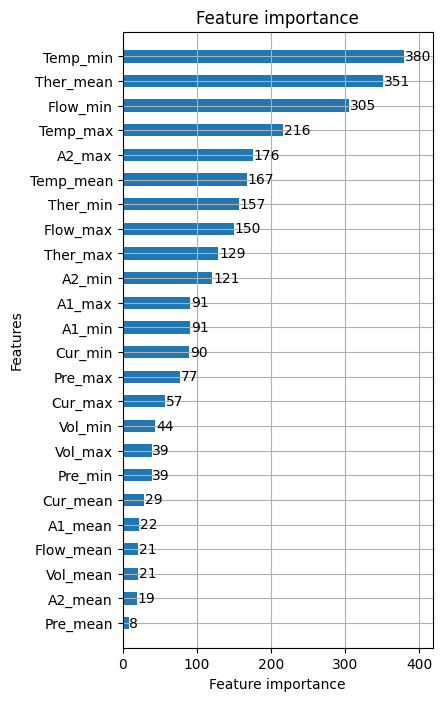

In [24]:
lgb.plot_importance(model_lgb,height=0.5,figsize=(4,8))

As the result of calculation, Flow min (The minimum of Volume Flow RateRMS) highly contributes to the decision of the class.

Valve1_data includes the anomaly data occurring when the valve is closed.

It leads to decrease Flow min when the valve is closed ,so this stat reflects the decision of the class mostly.

This result is coincident with the correlation coeficient result:

having the strong negative correlation -0.62 between "Volume Flow RateRMS" and "anomaly".

# 6. Conclusion

We use the TS data with supervised class label(normal, anomaly) and then construct the LightGBM model.

Before we implement data standardization, we perform Kaiser window data smoothing to remove the residual error.

In constructing the anomaly model, we introduce the window which is parameterized by look_back and
calculate the stats like mean, min and max within the window area.

We assign these stats as the explanatory variable.

Also, we assign the class label at right end of window as the objective variable.

After this, we train the model using the training data and search the hyper parameter.

Finally, we assess the generalization performance like the accuracy, f1score and confusion matrix.

We obtained the f1 score : 89 percent, so we can say that our model is good-balance in terms of recall and precision.

In [25]:
test_cm.sum()

1844

In [26]:
test_cm[1,0]

137

In [27]:
tn = test_cm[0,0]
tp = test_cm[1,1]
fn = test_cm[1,0]
fp = test_cm[0,1]

In [28]:
fn

137

### Recall

In [29]:
tp/(tp+fn)

0.8293897882938979

### MAR

In [30]:
fn/(fn+tp)

0.1706102117061021

In [31]:
test_pred.squeeze()

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
err_analysis = pd.DataFrame({
    'y_test' : test_y,
    'y_pred': test_pred.squeeze()
})

In [33]:
err_analysis[err_analysis['y_test']!=err_analysis['y_pred']].value_counts()

y_test  y_pred
1.0     0.0       137
0.0     1.0         2
dtype: int64

In [34]:
np.unique(y_test,return_counts=True)

(array([0., 1.]), array([1050,  803]))